<a href="https://colab.research.google.com/github/Y326s/ECE6397HW/blob/main/RNN_LSTM_Programming_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN and LSTM Programming Assignment

## Learning Objectives
By completing this assignment, you will:

1. **Implement RNNs from scratch** and understand their basic mechanics
2. **Observe vanishing/exploding gradient problems** through empirical experiments
3. **Implement LSTMs** and understand how gates solve gradient problems
4. **Apply both architectures to real stock data** and compare performance

## Assignment Overview
This assignment follows a progressive learning approach:
1. Start with basic RNN implementation and theory
2. Demonstrate vanishing/exploding gradient problems through experiments
3. Implement basic LSTM network
4. Apply both models to real-world stock prediction using PyTorch
5. Compare and analyze results

---

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"yfinance version: {yf.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cpu
NumPy version: 2.3.1
Pandas version: 2.3.2
yfinance version: 0.2.66
CUDA available: False


## Part 1: Basic RNN Implementation

### 1.1 Understanding RNN Architecture

Before implementing RNNs, let's understand their fundamental concept. Unlike feedforward neural networks, RNNs have a "memory" that allows them to process sequential data by maintaining hidden states.

**Key RNN Equations:**
- $h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$
- $y_t = W_{hy} h_t + b_y$

Where:
- $h_t$: hidden state at time $t$
- $x_t$: input at time $t$  
- $y_t$: output at time $t$
- $W_{hh}, W_{xh}, W_{hy}$: weight matrices
- $b_h, b_y$: bias vectors

### 1.2 Implement RNN from Scratch

**Task**: Implement a simple RNN class that can process sequences and maintain hidden states.

**Learning Goals**:
- Understand how hidden states carry information across time steps
- See how RNNs process sequential data


In [2]:
    class SimpleRNN:
        """A simple RNN implementation from scratch"""

        def __init__(self, input_size, hidden_size, output_size):
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

            # Initialize weights with Xavier initialization
            self.W_xh = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / (input_size + hidden_size))
            self.W_hh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / (hidden_size + hidden_size))
            self.W_hy = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / (hidden_size + output_size))

            # Initialize biases
            self.b_h = np.zeros((hidden_size, 1))
            self.b_y = np.zeros((output_size, 1))

            # Initialize hidden state
            self.h = np.zeros((hidden_size, 1))

        def forward(self, x):
            """Forward pass through the RNN"""

            "TODO: YOUR CODE HERE"
            # Update hidden state
            self.h = np.matmul(self.W_hh,self.h) + np.matmul(self.W_xh,x) + self.b_h

            # Compute output
            y = np.matmul(self.W_hy,self.h) + self.b_y

            return y, self.h.copy()

        def reset_hidden(self):
            """Reset hidden state to zeros"""
            self.h = np.zeros((self.hidden_size, 1))

        def get_parameters(self):
            """Get all parameters for visualization"""
            return {
                'W_xh': self.W_xh,
                'W_hh': self.W_hh,
                'W_hy': self.W_hy,
                'b_h': self.b_h,
                'b_y': self.b_y
            }

    # Test the RNN implementation
    print("Creating RNN with input_size=1, hidden_size=3, output_size=1")
    rnn = SimpleRNN(input_size=1, hidden_size=3, output_size=1)

    # Test with a simple sequence
    test_input = np.array([[0.5], [0.3], [0.8], [0.2]])
    print(f"\nTest input sequence: {test_input.flatten()}")

    # Forward pass
    outputs = []
    hidden_states = []

    for i, x in enumerate(test_input):
        x = x.reshape(-1, 1)  # Ensure column vector
        y, h = rnn.forward(x)
        outputs.append(y[0, 0])
        hidden_states.append(h.flatten())
        print(f"Step {i+1}: Input={x[0,0]:.3f}, Output={y[0,0]:.3f}, Hidden={h.flatten()}")

    print(f"\nFinal outputs: {outputs}")
    print("RNN implementation successful!")

Creating RNN with input_size=1, hidden_size=3, output_size=1

Test input sequence: [0.5 0.3 0.8 0.2]
Step 1: Input=0.500, Output=-0.183, Hidden=[ 0.17561497 -0.04888381  0.22899248]
Step 2: Input=0.300, Output=-0.199, Hidden=[0.23544459 0.04706018 0.14391186]
Step 3: Input=0.800, Output=-0.555, Hidden=[0.46219963 0.1182985  0.38885282]
Step 4: Input=0.200, Output=-0.524, Hidden=[0.4081108  0.34887765 0.10017013]

Final outputs: [np.float64(-0.1831212671325853), np.float64(-0.19891390176596957), np.float64(-0.5552502739345484), np.float64(-0.5243469259711545)]
RNN implementation successful!


## Part 2: Vanishing/Exploding Gradient Problem

### 2.1 Understanding the Problem

The vanishing gradient problem is one of the most significant challenges in training RNNs. Let's understand what causes this issue:

**Mathematical Root Cause:**
- In RNNs, gradients are computed using backpropagation through time (BPTT)
- The gradient at time step $t$ depends on the product of gradients from all future time steps
- If the gradient magnitude is consistently less than 1, it vanishes exponentially
- If the gradient magnitude is consistently greater than 1, it explodes exponentially

**Why This Happens:**
- The `tanh` activation function has a maximum derivative of 1.0
- Weight matrices are typically initialized with small values
- The product of many small numbers becomes extremely small

### 2.2 Empirical Demonstration

**Task**: Visualize how gradients behave differently with different weight magnitudes and sequence lengths.

**Learning Goals**:
- Understand why gradients vanish/explode or explode in RNNs
- See the exponential nature of gradient decay/growth
- Recognize the impact of sequence length on gradient problems

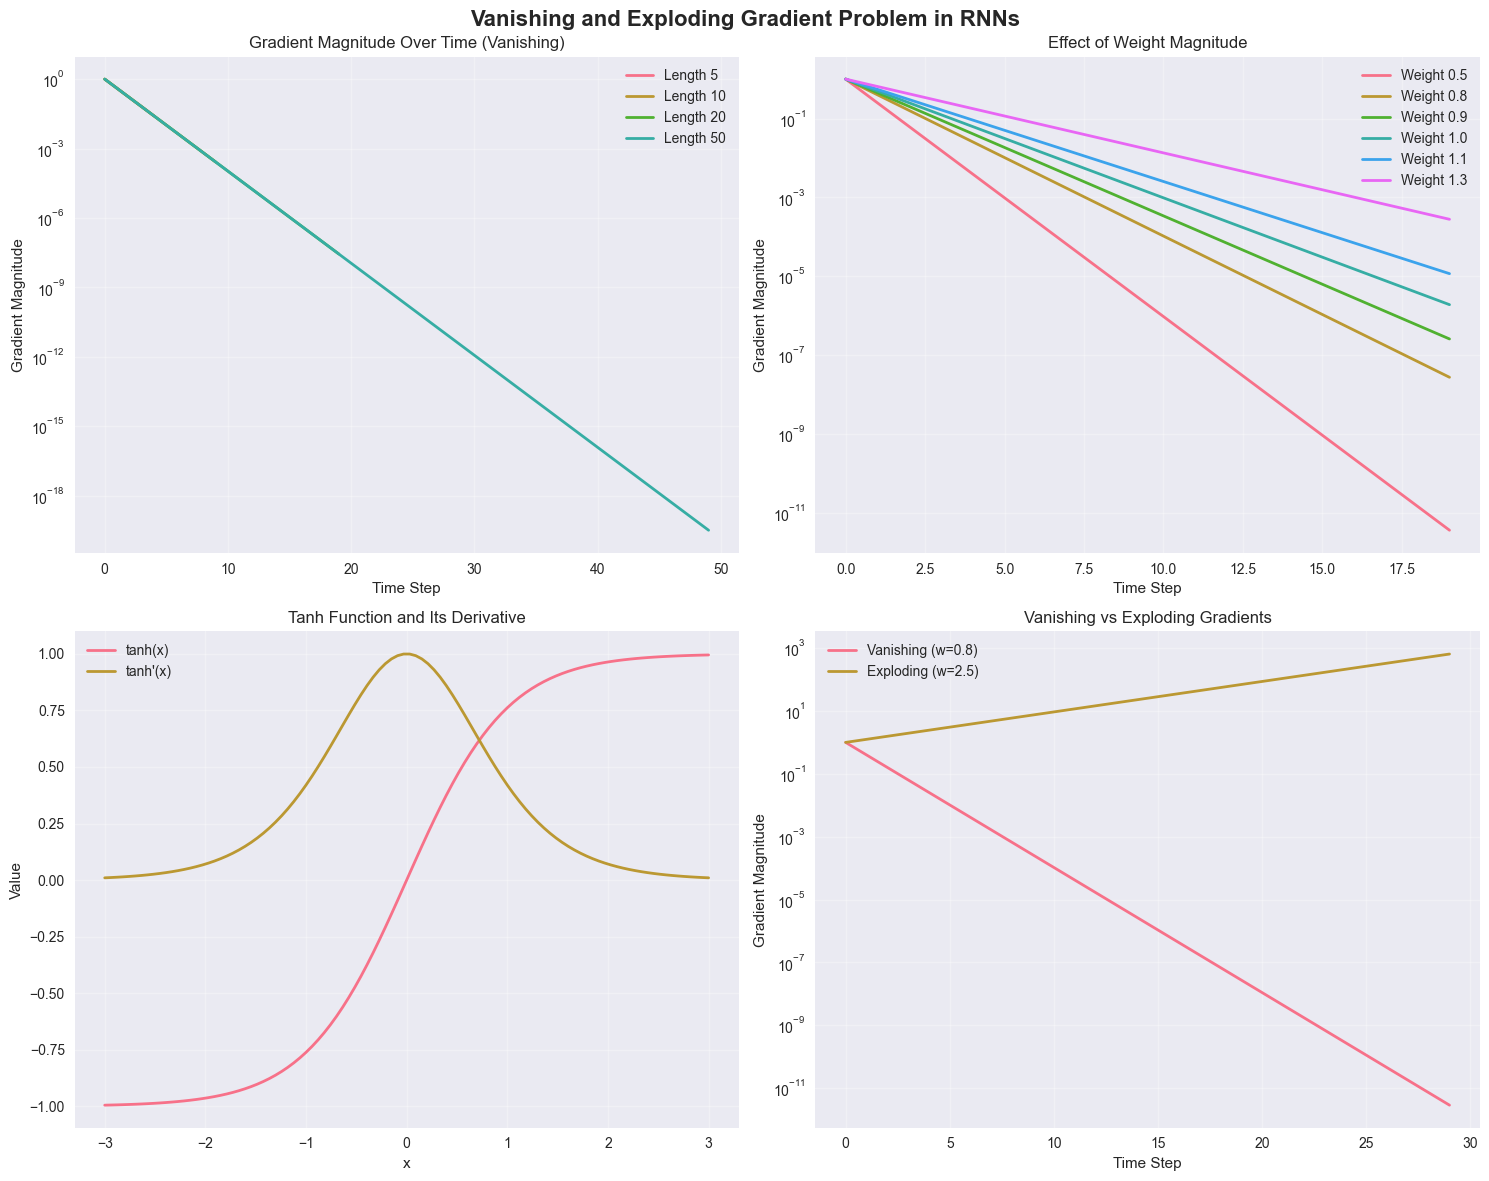

In [3]:
def demonstrate_gradient_problems():
    """Demonstrate how gradients vanish or explode in RNNs"""

    def tanh_derivative(x):
        """Derivative of tanh function"""
        return 1 - np.tanh(x)**2

    # Simulate gradient flow through time
    sequence_lengths = [5, 10, 20, 50]
    weight_values = [0.5, 0.8, 0.9, 1.0, 1.1, 1.3]  # Different weight magnitudes

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Vanishing and Exploding Gradient Problem in RNNs', fontsize=16, fontweight='bold')

    # Plot 1: Gradient magnitude over time for different sequence lengths
    ax1 = axes[0, 0]
    for length in sequence_lengths:
        time_steps = range(length)
        # Simulate gradient: starts at 1, multiplied by weight * tanh_derivative each step
        gradient = [1.0]
        for t in range(1, length):
            # Assume tanh_derivative ≈ 0.5 on average, weight = 0.8
            gradient.append(gradient[-1] * 0.8 * 0.5)

        ax1.plot(time_steps, gradient, label=f'Length {length}', linewidth=2)

    ax1.set_title('Gradient Magnitude Over Time (Vanishing)')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Gradient Magnitude')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Effect of different weight magnitudes
    ax2 = axes[0, 1]
    sequence_length = 20
    time_steps = range(sequence_length)

    for weight in weight_values:
        gradient = [1.0]
        for t in range(1, sequence_length):
            gradient.append(gradient[-1] * weight * 0.5)  # tanh_derivative ≈ 0.5

        ax2.plot(time_steps, gradient, label=f'Weight {weight}', linewidth=2)

    ax2.set_title('Effect of Weight Magnitude')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Gradient Magnitude')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Tanh derivative visualization
    ax3 = axes[1, 0]
    x_range = np.linspace(-3, 3, 100)
    tanh_values = np.tanh(x_range)
    tanh_deriv_values = tanh_derivative(x_range)

    ax3.plot(x_range, tanh_values, label='tanh(x)', linewidth=2)
    ax3.plot(x_range, tanh_deriv_values, label='tanh\'(x)', linewidth=2)
    ax3.set_title('Tanh Function and Its Derivative')
    ax3.set_xlabel('x')
    ax3.set_ylabel('Value')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Gradient flow comparison
    ax4 = axes[1, 1]
    time_steps = range(30)

    # Vanishing gradient (weight < 2)
    vanishing_grad = [1.0]
    for t in range(1, 30):
        vanishing_grad.append(vanishing_grad[-1] * 0.8 * 0.5)

    # Exploding gradient (weight > 2)
    exploding_grad = [1.0]
    for t in range(1, 30):
        exploding_grad.append(exploding_grad[-1] * 2.5 * 0.5)

    ax4.plot(time_steps, vanishing_grad, label='Vanishing (w=0.8)', linewidth=2)
    ax4.plot(time_steps, exploding_grad, label='Exploding (w=2.5)', linewidth=2)
    ax4.set_title('Vanishing vs Exploding Gradients')
    ax4.set_xlabel('Time Step')
    ax4.set_ylabel('Gradient Magnitude')
    ax4.set_yscale('log')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the demonstration
demonstrate_gradient_problems()

## Part 3: LSTM Implementation and Gates

### 3.1 Understanding LSTM Architecture

LSTMs solve the vanishing gradient problem through a sophisticated gating mechanism. Let's understand the key components:

**LSTM Gates:**
1. **Forget Gate** ($f_t$): Decides what information to discard from cell state
2. **Input Gate** ($i_t$): Decides what new information to store in cell state  
3. **Output Gate** ($o_t$): Decides what parts of cell state to output

**Key Equations:**
- $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$
- $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
- $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$
- $C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$
- $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$
- $h_t = o_t * \tanh(C_t)$

### 3.2 Implement LSTM from Scratch

**Task**: Implement a simple LSTM class that demonstrates the gating mechanism.

**Learning Goals**:
- Understand how gates control information flow
- See how cell state maintains long-term memory
- Visualize gate behavior during sequence processing

In [3]:
class SimpleLSTM:
    """A simple LSTM implementation from scratch"""

    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights for all gates and cell state
        # We'll combine input and hidden states: [h_{t-1}, x_t]
        combined_size = hidden_size + input_size

        # Forget gate weights
        self.W_f = np.random.randn(hidden_size, combined_size) * np.sqrt(2.0 / combined_size)
        self.b_f = np.zeros((hidden_size, 1))

        # Input gate weights
        self.W_i = np.random.randn(hidden_size, combined_size) * np.sqrt(2.0 / combined_size)
        self.b_i = np.zeros((hidden_size, 1))

        # Candidate values weights
        self.W_C = np.random.randn(hidden_size, combined_size) * np.sqrt(2.0 / combined_size)
        self.b_C = np.zeros((hidden_size, 1))

        # Output gate weights
        self.W_o = np.random.randn(hidden_size, combined_size) * np.sqrt(2.0 / combined_size)
        self.b_o = np.zeros((hidden_size, 1))

        # Output layer weights
        self.W_y = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b_y = np.zeros((output_size, 1))

        # Initialize hidden state and cell state
        self.h = np.zeros((hidden_size, 1))
        self.C = np.zeros((hidden_size, 1))

    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to prevent overflow

    def forward(self, x):
        """Forward pass through the LSTM"""

        "TODO: YOUR CODE HERE"
        # ft = self.sigmoid(np.matmul(self.W_f,np.concatenate((self.h,x),axis=10)) + self.b_f)
        # it = self.sigmoid(np.matmul(self.W_i,np.concatenate((self.h,x),axis=10)) + self.b_i)
        # ot = self.sigmoid(np.matmul(self.W_o,np.concatenate((self.h,x),axis=10)) + self.b_o)
        (f_t, i_t, C_tilde, o_t) = self.get_gates(x)
        self.C = f_t*self.C + i_t*C_tilde
        self.h = o_t*np.tanh(self.C)
        y = np.matmul(self.W_y,self.h) + self.b_y
        
        return y, self.h.copy(), self.C.copy()

    def reset_states(self):
        """Reset hidden state and cell state to zeros"""
        self.h = np.zeros((self.hidden_size, 1))
        self.C = np.zeros((self.hidden_size, 1))

    def get_gates(self, x):
        """Get gate values for visualization"""
        combined = np.vstack([self.h, x])

        f_t = self.sigmoid(self.W_f @ combined + self.b_f)
        i_t = self.sigmoid(self.W_i @ combined + self.b_i)
        C_tilde = np.tanh(self.W_C @ combined + self.b_C)
        o_t = self.sigmoid(self.W_o @ combined + self.b_o)

        return f_t, i_t, C_tilde, o_t

# Test the LSTM implementation
print("Creating LSTM with input_size=1, hidden_size=4, output_size=1")
lstm = SimpleLSTM(input_size=1, hidden_size=4, output_size=1)

# Test with a simple sequence
test_input = np.array([[0.5], [0.3], [0.8], [0.2]])
print(f"\nTest input sequence: {test_input.flatten()}")

# Forward pass
outputs = []
hidden_states = []
cell_states = []
gate_values = []

for i, x in enumerate(test_input):
    x = x.reshape(-1, 1)  # Ensure column vector
    y, h, C = lstm.forward(x)
    f_t, i_t, C_tilde, o_t = lstm.get_gates(x)

    outputs.append(y[0, 0])
    hidden_states.append(h.flatten())
    cell_states.append(C.flatten())
    gate_values.append({
        'forget': f_t.flatten(),
        'input': i_t.flatten(),
        'candidate': C_tilde.flatten(),
        'output': o_t.flatten()
    })

    print(f"Step {i+1}: Input={x[0,0]:.3f}, Output={y[0,0]:.3f}")
    print(f"  Hidden: {h.flatten()}")
    print(f"  Cell: {C.flatten()}")
    print(f"  Gates - Forget: {f_t.flatten()}, Input: {i_t.flatten()}, Output: {o_t.flatten()}")

print(f"\nFinal outputs: {outputs}")
print("LSTM implementation successful!")

Creating LSTM with input_size=1, hidden_size=4, output_size=1

Test input sequence: [0.5 0.3 0.8 0.2]
Step 1: Input=0.500, Output=-0.054
  Hidden: [ 0.05321197  0.04213714 -0.03953023 -0.17609139]
  Cell: [ 0.15418636  0.09685154 -0.07326879 -0.39472766]
  Gates - Forget: [0.40149142 0.50703586 0.48458433 0.6004545 ], Input: [0.55567977 0.40090276 0.34102676 0.56843688], Output: [0.35404906 0.44206803 0.55492712 0.48978384]
Step 2: Input=0.300, Output=-0.060
  Hidden: [ 0.06495571  0.08250803 -0.04963018 -0.24049783]
  Cell: [ 0.15843349  0.1783865  -0.09236733 -0.52156341]
  Gates - Forget: [0.44629119 0.539848   0.49217986 0.59611672], Input: [0.56503722 0.45219131 0.38377145 0.52922838], Output: [0.41498892 0.47219157 0.54854668 0.51300025]
Step 3: Input=0.800, Output=-0.075
  Hidden: [ 0.07932873  0.1083955  -0.0785443  -0.34292912]
  Cell: [ 0.29746627  0.27132355 -0.13430311 -0.89012079]
  Gates - Forget: [0.3473081  0.52205402 0.4726971  0.677662  ], Input: [0.60780297 0.3479118

## Part 4: PyTorch Implementation for Stock Data

### 4.1 Data Preparation

**Task**: Download and preprocess real stock data for training RNN and LSTM models.

**Learning Goals**:
- Learn how to handle real-world time series data
- Understand data preprocessing for sequence models
- Create proper train/validation/test splits for time series

In [2]:
def download_stock_data(symbol='AAPL', period='5y'):
    """
    Download stock price data from Yahoo Finance

    Args:
        symbol (str): Stock symbol (e.g., 'AAPL', 'MSFT', 'TSLA')
        period (str): Time period ('1y', '2y', '3y', etc.)

    Returns:
        pandas.DataFrame: Stock price data
    """
    print(f"Downloading {symbol} stock data for {period}...")

    # Download data
    ticker = yf.Ticker(symbol)
    data = ticker.history(period=period)

    if data.empty:
        print(f"Error: No data found for symbol {symbol}")
        return None

    print(f"Successfully downloaded {len(data)} days of data")
    print(f"Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")

    return data


def preprocess_stock_data(data, sequence_length=30):
    """
    Preprocess stock data for RNN/LSTM training

    Args:
        data (pd.DataFrame): Raw stock data
        sequence_length (int): Number of days to use for prediction

    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test, scaler)
    """
    # Use only closing prices
    prices = data['Close'].values.reshape(-1, 1)

    # Normalize data to [0, 1] range
    scaler = MinMaxScaler()
    prices_normalized = scaler.fit_transform(prices)

    # Create sequences
    X, y = [], []
    for i in range(len(prices_normalized) - sequence_length):
        X.append(prices_normalized[i:i+sequence_length])
        y.append(prices_normalized[i+sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Split data: 70% train, 15% validation, 15% test
    train_size = int(0.7 * len(X))
    val_size = int(0.15 * len(X))

    X_train = X[:train_size]
    X_val = X[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]

    y_train = y[:train_size]
    y_val = y[train_size:train_size + val_size]
    y_test = y[train_size + val_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

# Download and preprocess data
stock_data = download_stock_data('AAPL', '5y')
X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocess_stock_data(stock_data)

print("\nData preprocessing complete!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Sequence length: {X_train.shape[1]}")
print(f"Features: {X_train.shape[2]}")

Successfully downloaded 1255 days of data
Date range: 2020-10-21 to 2025-10-20

Data preprocessing complete!
Training samples: 857
Validation samples: 183
Test samples: 185
Sequence length: 30
Features: 1


### 4.2 PyTorch RNN and LSTM Models

**Task**: Implement RNN and LSTM models using PyTorch for stock price prediction.

**Learning Goals**:
- Learn PyTorch implementation of RNNs and LSTMs
- Understand model architecture design for time series
- Implement proper training loops with validation

In [6]:
class StockRNN(nn.Module):
    """PyTorch RNN model for stock price prediction"""

    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(StockRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        "TODO: YOUR CODE HERE"
        # RNN layer using Pytorch
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # RNN forward pass
        out, _ = self.rnn(x, h0)

        # Take the last output
        out = self.fc(out[:, -1, :])

        return out


class StockLSTM(nn.Module):
    """PyTorch LSTM model for stock price prediction"""

    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        "TODO: YOUR CODE HERE"
        # LSTM layer using Pytorch
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Take the last output
        out = self.fc(out[:, -1, :])

        return out


# Convert data to PyTorch tensors
def create_tensors(X_train, X_val, X_test, y_train, y_val, y_test):
    """Convert numpy arrays to PyTorch tensors"""
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.FloatTensor(y_train)
    y_val_tensor = torch.FloatTensor(y_val)
    y_test_tensor = torch.FloatTensor(y_test)

    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor


# Create tensors
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = create_tensors(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("PyTorch models and data loaders created successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

PyTorch models and data loaders created successfully!
Training batches: 27
Validation batches: 6
Test batches: 6


### 4.3 Training and Evaluation

**Task**: Train both RNN and LSTM models and compare their performance.

**Learning Goals**:
- Learn how to train sequence models effectively
- Understand evaluation metrics for time series prediction
- Compare RNN vs LSTM performance on real data

In [7]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, device='cpu'):
    """Train a PyTorch model"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            "TODO: YOUR CODE HERE"
            "Set up Pytorch optimizer and perform gradient descent step"

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses


def evaluate_model(model, test_loader, scaler, device='cpu'):
    """Evaluate a trained model"""
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Convert back to original scale
    predictions_original = scaler.inverse_transform(predictions)
    actuals_original = scaler.inverse_transform(actuals)

    # Calculate metrics
    mse = mean_squared_error(actuals_original, predictions_original)
    mae = mean_absolute_error(actuals_original, predictions_original)
    rmse = np.sqrt(mse)

    return predictions_original, actuals_original, mse, mae, rmse


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models
rnn_model = StockRNN(input_size=1, hidden_size=64, num_layers=2, output_size=1)
lstm_model = StockLSTM(input_size=1, hidden_size=64, num_layers=2, output_size=1)

print("\nTraining RNN model...")
rnn_train_losses, rnn_val_losses = train_model(rnn_model, train_loader, val_loader, num_epochs=100, device=device)

print("\nTraining LSTM model...")
lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, num_epochs=100, device=device)

print("\nTraining completed!")

Using device: cpu

Training RNN model...
Epoch [20/100], Train Loss: 0.000703, Val Loss: 0.003542
Epoch [40/100], Train Loss: 0.000495, Val Loss: 0.001202
Epoch [60/100], Train Loss: 0.000384, Val Loss: 0.001469
Epoch [80/100], Train Loss: 0.000401, Val Loss: 0.003160
Epoch [100/100], Train Loss: 0.000452, Val Loss: 0.001264

Training LSTM model...
Epoch [20/100], Train Loss: 0.000841, Val Loss: 0.001353
Epoch [40/100], Train Loss: 0.000631, Val Loss: 0.000852
Epoch [60/100], Train Loss: 0.000467, Val Loss: 0.001560
Epoch [80/100], Train Loss: 0.000424, Val Loss: 0.001836
Epoch [100/100], Train Loss: 0.000395, Val Loss: 0.000511

Training completed!


## Part 5: Comparison and Analysis

### 5.1 Performance Comparison

**Task**: Evaluate and compare the performance of RNN and LSTM models.

**Learning Goals**:
- Understand how to measure model performance for time series
- Analyze the differences between RNN and LSTM performance
- Visualize predictions vs actual values

In [8]:
# Evaluate both models
print("Evaluating RNN model...")
rnn_predictions, rnn_actuals, rnn_mse, rnn_mae, rnn_rmse = evaluate_model(rnn_model, test_loader, scaler, device)

print("Evaluating LSTM model...")
lstm_predictions, lstm_actuals, lstm_mse, lstm_mae, lstm_rmse = evaluate_model(lstm_model, test_loader, scaler, device)

# Print performance metrics
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(f"RNN  - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}, RMSE: {rnn_rmse:.4f}")
print(f"LSTM - MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")
print("="*50)

# Calculate improvement
mse_improvement = ((rnn_mse - lstm_mse) / rnn_mse) * 100
mae_improvement = ((rnn_mae - lstm_mae) / rnn_mae) * 100
rmse_improvement = ((rnn_rmse - lstm_rmse) / rnn_rmse) * 100

print(f"\nLSTM Improvement over RNN:")
print(f"MSE:  {mse_improvement:.2f}%")
print(f"MAE:  {mae_improvement:.2f}%")
print(f"RMSE: {rmse_improvement:.2f}%")

Evaluating RNN model...
Evaluating LSTM model...

PERFORMANCE COMPARISON
RNN  - MSE: 44.3135, MAE: 5.3379, RMSE: 6.6568
LSTM - MSE: 23.8114, MAE: 3.4561, RMSE: 4.8797

LSTM Improvement over RNN:
MSE:  46.27%
MAE:  35.25%
RMSE: 26.70%


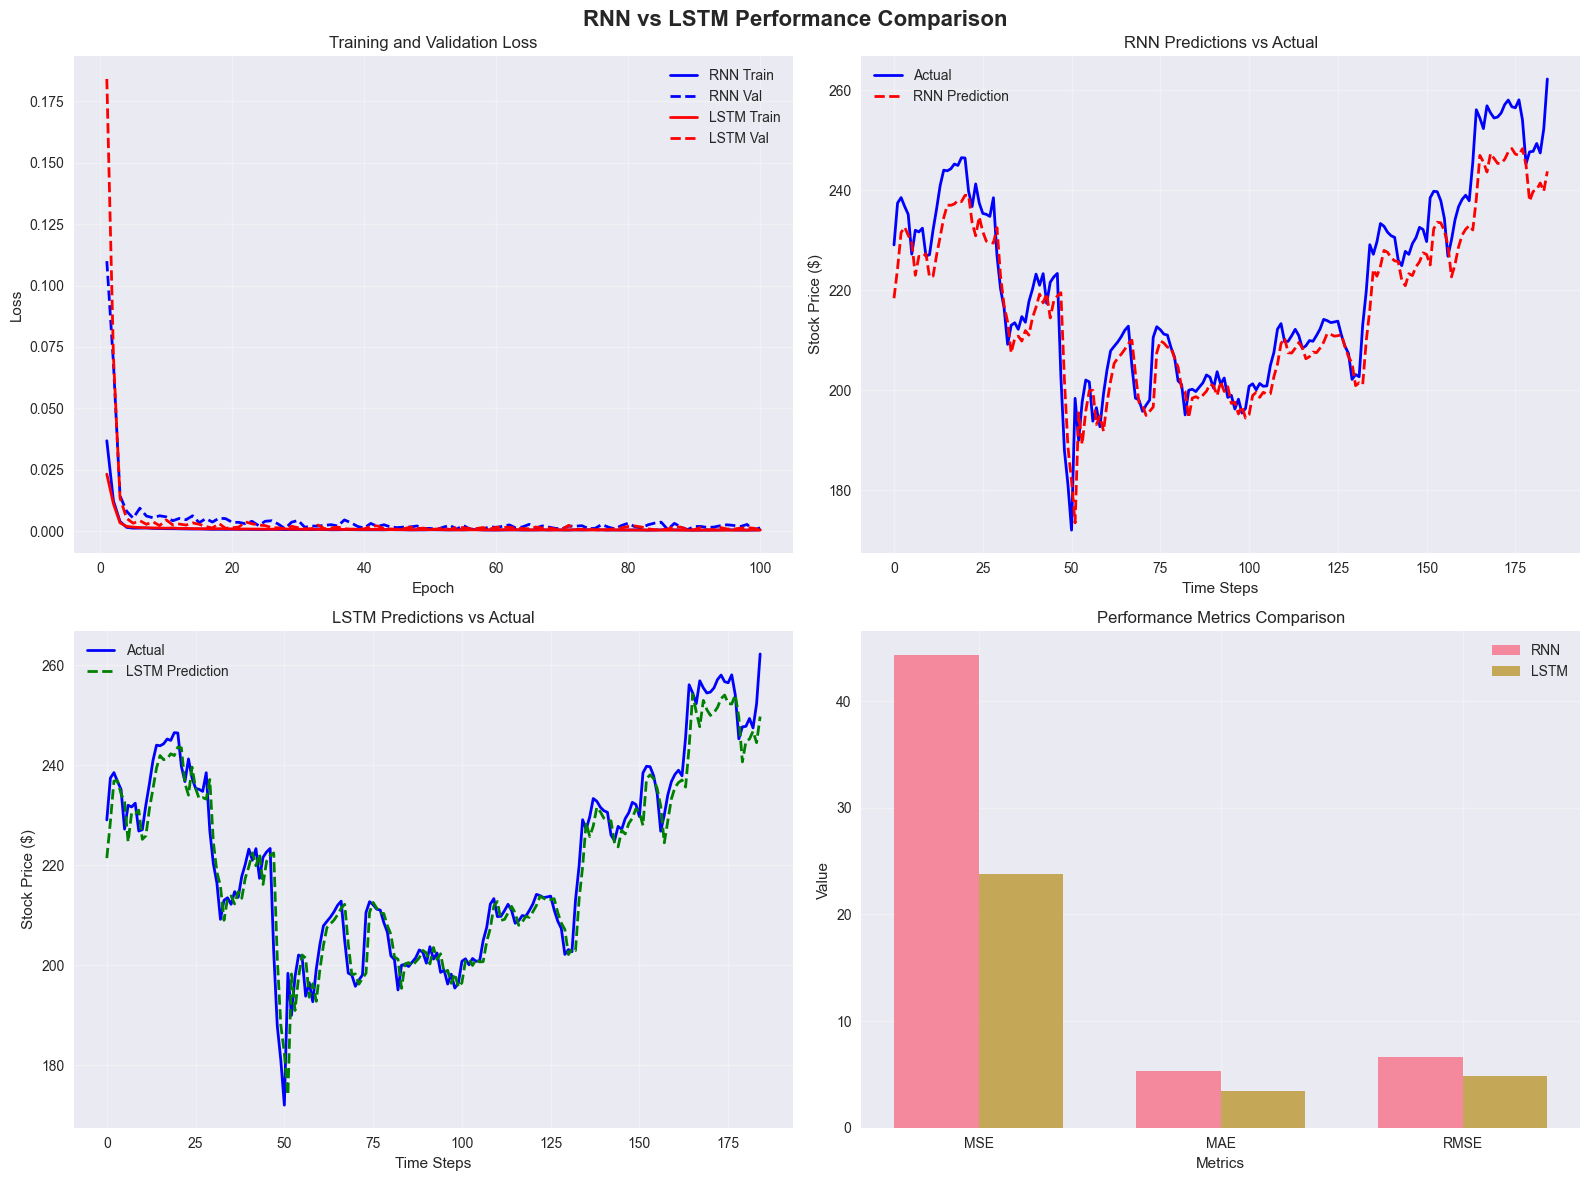


FINAL ANALYSIS

Key Findings:
1. LSTM outperforms RNN by 46.3% in MSE
2. LSTM outperforms RNN by 35.3% in MAE
3. LSTM outperforms RNN by 26.7% in RMSE


In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RNN vs LSTM Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Training curves
ax1 = axes[0, 0]
epochs = range(1, len(rnn_train_losses) + 1)
ax1.plot(epochs, rnn_train_losses, 'b-', label='RNN Train', linewidth=2)
ax1.plot(epochs, rnn_val_losses, 'b--', label='RNN Val', linewidth=2)
ax1.plot(epochs, lstm_train_losses, 'r-', label='LSTM Train', linewidth=2)
ax1.plot(epochs, lstm_val_losses, 'r--', label='LSTM Val', linewidth=2)
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual (RNN)
ax2 = axes[0, 1]
ax2.plot(rnn_actuals, 'b-', label='Actual', linewidth=2)
ax2.plot(rnn_predictions, 'r--', label='RNN Prediction', linewidth=2)
ax2.set_title('RNN Predictions vs Actual')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Stock Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Predictions vs Actual (LSTM)
ax3 = axes[1, 0]
ax3.plot(lstm_actuals, 'b-', label='Actual', linewidth=2)
ax3.plot(lstm_predictions, 'g--', label='LSTM Prediction', linewidth=2)
ax3.set_title('LSTM Predictions vs Actual')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Stock Price ($)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Performance metrics comparison
ax4 = axes[1, 1]
metrics = ['MSE', 'MAE', 'RMSE']
rnn_values = [rnn_mse, rnn_mae, rnn_rmse]
lstm_values = [lstm_mse, lstm_mae, lstm_rmse]

x = np.arange(len(metrics))
width = 0.35

ax4.bar(x - width/2, rnn_values, width, label='RNN', alpha=0.8)
ax4.bar(x + width/2, lstm_values, width, label='LSTM', alpha=0.8)
ax4.set_title('Performance Metrics Comparison')
ax4.set_xlabel('Metrics')
ax4.set_ylabel('Value')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final analysis
print("\n" + "="*60)
print("FINAL ANALYSIS")
print("="*60)
print("\nKey Findings:")
print(f"1. LSTM outperforms RNN by {mse_improvement:.1f}% in MSE")
print(f"2. LSTM outperforms RNN by {mae_improvement:.1f}% in MAE")
print(f"3. LSTM outperforms RNN by {rmse_improvement:.1f}% in RMSE")

In [ ]:
### TODO: YOUR CODE HERE

#  Try different hyperparameters (hidden size, number of layers, learning rate). Describe what you observe when varying these hyperparameters.

# 1. LSTM learning rate 0.001 -> 0.005
    # Conclusion: LSTM performs even better

# ==================================================
# PERFORMANCE COMPARISON
# ==================================================
# RNN  - MSE: 163.9784, MAE: 10.6881, RMSE: 12.8054
# LSTM - MSE: 37.5496, MAE: 4.5766, RMSE: 6.1278
# ==================================================
# LSTM Improvement over RNN:
# MSE:  46.27% -> 77.10%
# MAE:  35.25% -> 57.18%
# RMSE: 26.70% -> 52.15%



# 2. number of layers for both RNN and LSTM 2 -> 4
    # Conclusion: Both RNN and LSTM perform better according to MSE, MAR, and RMSE
                # LSTM also outperforms more

# ==================================================
# PERFORMANCE COMPARISON
# ==================================================
# RNN  - MSE: 53.6152, MAE: 6.0412, RMSE: 7.3222
# LSTM - MSE: 22.8181, MAE: 3.3194, RMSE: 4.7768
# ==================================================
# LSTM Improvement over RNN:
# MSE:  57.44%
# MAE:  45.05%
# RMSE: 34.76%


# 2. hidden size for both RNN and LSTM 64 -> 128
    # Conclusion: Both RNN and LSTM perform better according to MSE, MAR, and RMSE; even better than increasing number of layers from 2 -> 4
                # But LSTM does not relatively more outperforms RNN compared with the original case

# ==================================================
# PERFORMANCE COMPARISON
# ==================================================
# RNN  - MSE: 44.3133, MAE: 5.3379, RMSE: 6.6568
# LSTM - MSE: 23.8113, MAE: 3.4561, RMSE: 4.8797
# ==================================================

# LSTM Improvement over RNN:
# MSE:  46.27%
# MAE:  35.25%
# RMSE: 26.70%

In [7]:
#  Try different learning rate for LSTM. 


def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.005, device='cpu'):
    """Train a PyTorch model"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            "TODO: YOUR CODE HERE"
            "Set up Pytorch optimizer and perform gradient descent step"

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses


def evaluate_model(model, test_loader, scaler, device='cpu'):
    """Evaluate a trained model"""
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Convert back to original scale
    predictions_original = scaler.inverse_transform(predictions)
    actuals_original = scaler.inverse_transform(actuals)

    # Calculate metrics
    mse = mean_squared_error(actuals_original, predictions_original)
    mae = mean_absolute_error(actuals_original, predictions_original)
    rmse = np.sqrt(mse)

    return predictions_original, actuals_original, mse, mae, rmse


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models
rnn_model = StockRNN(input_size=1, hidden_size=64, num_layers=2, output_size=1)
lstm_model = StockLSTM(input_size=1, hidden_size=64, num_layers=2, output_size=1)

print("\nTraining RNN model...")
rnn_train_losses, rnn_val_losses = train_model(rnn_model, train_loader, val_loader, num_epochs=100, device=device)

print("\nTraining LSTM model...")
lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, num_epochs=100, device=device)

print("\nTraining completed!")

Using device: cpu

Training RNN model...
Epoch [20/100], Train Loss: 0.000629, Val Loss: 0.005081
Epoch [40/100], Train Loss: 0.000502, Val Loss: 0.002548
Epoch [60/100], Train Loss: 0.000364, Val Loss: 0.002134
Epoch [80/100], Train Loss: 0.000418, Val Loss: 0.007984
Epoch [100/100], Train Loss: 0.000360, Val Loss: 0.005962

Training LSTM model...
Epoch [20/100], Train Loss: 0.000545, Val Loss: 0.000725
Epoch [40/100], Train Loss: 0.000422, Val Loss: 0.000793
Epoch [60/100], Train Loss: 0.000349, Val Loss: 0.000830
Epoch [80/100], Train Loss: 0.000455, Val Loss: 0.001360
Epoch [100/100], Train Loss: 0.000391, Val Loss: 0.000963

Training completed!


In [8]:
# Evaluate both models
print("Evaluating RNN model...")
rnn_predictions, rnn_actuals, rnn_mse, rnn_mae, rnn_rmse = evaluate_model(rnn_model, test_loader, scaler, device)

print("Evaluating LSTM model...")
lstm_predictions, lstm_actuals, lstm_mse, lstm_mae, lstm_rmse = evaluate_model(lstm_model, test_loader, scaler, device)

# Print performance metrics
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(f"RNN  - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}, RMSE: {rnn_rmse:.4f}")
print(f"LSTM - MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")
print("="*50)

# Calculate improvement
mse_improvement = ((rnn_mse - lstm_mse) / rnn_mse) * 100
mae_improvement = ((rnn_mae - lstm_mae) / rnn_mae) * 100
rmse_improvement = ((rnn_rmse - lstm_rmse) / rnn_rmse) * 100

print(f"\nLSTM Improvement over RNN:")
print(f"MSE:  {mse_improvement:.2f}%")
print(f"MAE:  {mae_improvement:.2f}%")
print(f"RMSE: {rmse_improvement:.2f}%")

Evaluating RNN model...
Evaluating LSTM model...

PERFORMANCE COMPARISON
RNN  - MSE: 163.9784, MAE: 10.6881, RMSE: 12.8054
LSTM - MSE: 37.5496, MAE: 4.5766, RMSE: 6.1278

LSTM Improvement over RNN:
MSE:  77.10%
MAE:  57.18%
RMSE: 52.15%


In [8]:
# Try different number of layers

class StockRNN(nn.Module):
    """PyTorch RNN model for stock price prediction"""

    def __init__(self, input_size=1, hidden_size=64, num_layers=4, output_size=1, dropout=0.2):
        super(StockRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        "TODO: YOUR CODE HERE"
        # RNN layer using Pytorch
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # RNN forward pass
        out, _ = self.rnn(x, h0)

        # Take the last output
        out = self.fc(out[:, -1, :])

        return out


class StockLSTM(nn.Module):
    """PyTorch LSTM model for stock price prediction"""

    def __init__(self, input_size=1, hidden_size=64, num_layers=4, output_size=1, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        "TODO: YOUR CODE HERE"
        # LSTM layer using Pytorch
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Take the last output
        out = self.fc(out[:, -1, :])

        return out


# Convert data to PyTorch tensors
def create_tensors(X_train, X_val, X_test, y_train, y_val, y_test):
    """Convert numpy arrays to PyTorch tensors"""
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.FloatTensor(y_train)
    y_val_tensor = torch.FloatTensor(y_val)
    y_test_tensor = torch.FloatTensor(y_test)

    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor


# Create tensors
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = create_tensors(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("PyTorch models and data loaders created successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

PyTorch models and data loaders created successfully!
Training batches: 27
Validation batches: 6
Test batches: 6


In [9]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, device='cpu'):
    """Train a PyTorch model"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            "TODO: YOUR CODE HERE"
            "Set up Pytorch optimizer and perform gradient descent step"

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses


def evaluate_model(model, test_loader, scaler, device='cpu'):
    """Evaluate a trained model"""
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Convert back to original scale
    predictions_original = scaler.inverse_transform(predictions)
    actuals_original = scaler.inverse_transform(actuals)

    # Calculate metrics
    mse = mean_squared_error(actuals_original, predictions_original)
    mae = mean_absolute_error(actuals_original, predictions_original)
    rmse = np.sqrt(mse)

    return predictions_original, actuals_original, mse, mae, rmse


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models
rnn_model = StockRNN(input_size=1, hidden_size=64, num_layers=2, output_size=1)
lstm_model = StockLSTM(input_size=1, hidden_size=64, num_layers=2, output_size=1)

print("\nTraining RNN model...")
rnn_train_losses, rnn_val_losses = train_model(rnn_model, train_loader, val_loader, num_epochs=100, device=device)

print("\nTraining LSTM model...")
lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, num_epochs=100, device=device)

print("\nTraining completed!")

Using device: cpu

Training RNN model...
Epoch [20/100], Train Loss: 0.000694, Val Loss: 0.004054
Epoch [40/100], Train Loss: 0.000482, Val Loss: 0.001047
Epoch [60/100], Train Loss: 0.000415, Val Loss: 0.000471
Epoch [80/100], Train Loss: 0.000482, Val Loss: 0.001537
Epoch [100/100], Train Loss: 0.000356, Val Loss: 0.001670

Training LSTM model...
Epoch [20/100], Train Loss: 0.000776, Val Loss: 0.001100
Epoch [40/100], Train Loss: 0.000659, Val Loss: 0.000677
Epoch [60/100], Train Loss: 0.000549, Val Loss: 0.000870
Epoch [80/100], Train Loss: 0.000384, Val Loss: 0.000579
Epoch [100/100], Train Loss: 0.000367, Val Loss: 0.000475

Training completed!


In [10]:
# Evaluate both models
print("Evaluating RNN model...")
rnn_predictions, rnn_actuals, rnn_mse, rnn_mae, rnn_rmse = evaluate_model(rnn_model, test_loader, scaler, device)

print("Evaluating LSTM model...")
lstm_predictions, lstm_actuals, lstm_mse, lstm_mae, lstm_rmse = evaluate_model(lstm_model, test_loader, scaler, device)

# Print performance metrics
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(f"RNN  - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}, RMSE: {rnn_rmse:.4f}")
print(f"LSTM - MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")
print("="*50)

# Calculate improvement
mse_improvement = ((rnn_mse - lstm_mse) / rnn_mse) * 100
mae_improvement = ((rnn_mae - lstm_mae) / rnn_mae) * 100
rmse_improvement = ((rnn_rmse - lstm_rmse) / rnn_rmse) * 100

print(f"\nLSTM Improvement over RNN:")
print(f"MSE:  {mse_improvement:.2f}%")
print(f"MAE:  {mae_improvement:.2f}%")
print(f"RMSE: {rmse_improvement:.2f}%")

Evaluating RNN model...
Evaluating LSTM model...

PERFORMANCE COMPARISON
RNN  - MSE: 53.6152, MAE: 6.0412, RMSE: 7.3222
LSTM - MSE: 22.8181, MAE: 3.3194, RMSE: 4.7768

LSTM Improvement over RNN:
MSE:  57.44%
MAE:  45.05%
RMSE: 34.76%


In [3]:
# Try different number of layers

class StockRNN(nn.Module):
    """PyTorch RNN model for stock price prediction"""

    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, dropout=0.2):
        super(StockRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        "TODO: YOUR CODE HERE"
        # RNN layer using Pytorch
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # RNN forward pass
        out, _ = self.rnn(x, h0)

        # Take the last output
        out = self.fc(out[:, -1, :])

        return out


class StockLSTM(nn.Module):
    """PyTorch LSTM model for stock price prediction"""

    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        "TODO: YOUR CODE HERE"
        # LSTM layer using Pytorch
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))

        # Take the last output
        out = self.fc(out[:, -1, :])

        return out


# Convert data to PyTorch tensors
def create_tensors(X_train, X_val, X_test, y_train, y_val, y_test):
    """Convert numpy arrays to PyTorch tensors"""
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.FloatTensor(y_train)
    y_val_tensor = torch.FloatTensor(y_val)
    y_test_tensor = torch.FloatTensor(y_test)

    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor


# Create tensors
X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = create_tensors(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("PyTorch models and data loaders created successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

PyTorch models and data loaders created successfully!
Training batches: 27
Validation batches: 6
Test batches: 6


In [4]:
def train_model(model, train_loader, val_loader, num_epochs=100, learning_rate=0.001, device='cpu'):
    """Train a PyTorch model"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            "TODO: YOUR CODE HERE"
            "Set up Pytorch optimizer and perform gradient descent step"

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return train_losses, val_losses


def evaluate_model(model, test_loader, scaler, device='cpu'):
    """Evaluate a trained model"""
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Convert back to original scale
    predictions_original = scaler.inverse_transform(predictions)
    actuals_original = scaler.inverse_transform(actuals)

    # Calculate metrics
    mse = mean_squared_error(actuals_original, predictions_original)
    mae = mean_absolute_error(actuals_original, predictions_original)
    rmse = np.sqrt(mse)

    return predictions_original, actuals_original, mse, mae, rmse


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models
rnn_model = StockRNN(input_size=1, hidden_size=64, num_layers=2, output_size=1)
lstm_model = StockLSTM(input_size=1, hidden_size=64, num_layers=2, output_size=1)

print("\nTraining RNN model...")
rnn_train_losses, rnn_val_losses = train_model(rnn_model, train_loader, val_loader, num_epochs=100, device=device)

print("\nTraining LSTM model...")
lstm_train_losses, lstm_val_losses = train_model(lstm_model, train_loader, val_loader, num_epochs=100, device=device)

print("\nTraining completed!")

Using device: cpu

Training RNN model...
Epoch [20/100], Train Loss: 0.000703, Val Loss: 0.003542
Epoch [40/100], Train Loss: 0.000495, Val Loss: 0.001202
Epoch [60/100], Train Loss: 0.000384, Val Loss: 0.001469
Epoch [80/100], Train Loss: 0.000401, Val Loss: 0.003160
Epoch [100/100], Train Loss: 0.000452, Val Loss: 0.001264

Training LSTM model...
Epoch [20/100], Train Loss: 0.000841, Val Loss: 0.001353
Epoch [40/100], Train Loss: 0.000631, Val Loss: 0.000852
Epoch [60/100], Train Loss: 0.000467, Val Loss: 0.001560
Epoch [80/100], Train Loss: 0.000424, Val Loss: 0.001836
Epoch [100/100], Train Loss: 0.000395, Val Loss: 0.000511

Training completed!


In [5]:
# Evaluate both models
print("Evaluating RNN model...")
rnn_predictions, rnn_actuals, rnn_mse, rnn_mae, rnn_rmse = evaluate_model(rnn_model, test_loader, scaler, device)

print("Evaluating LSTM model...")
lstm_predictions, lstm_actuals, lstm_mse, lstm_mae, lstm_rmse = evaluate_model(lstm_model, test_loader, scaler, device)

# Print performance metrics
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(f"RNN  - MSE: {rnn_mse:.4f}, MAE: {rnn_mae:.4f}, RMSE: {rnn_rmse:.4f}")
print(f"LSTM - MSE: {lstm_mse:.4f}, MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")
print("="*50)

# Calculate improvement
mse_improvement = ((rnn_mse - lstm_mse) / rnn_mse) * 100
mae_improvement = ((rnn_mae - lstm_mae) / rnn_mae) * 100
rmse_improvement = ((rnn_rmse - lstm_rmse) / rnn_rmse) * 100

print(f"\nLSTM Improvement over RNN:")
print(f"MSE:  {mse_improvement:.2f}%")
print(f"MAE:  {mae_improvement:.2f}%")
print(f"RMSE: {rmse_improvement:.2f}%")

Evaluating RNN model...
Evaluating LSTM model...

PERFORMANCE COMPARISON
RNN  - MSE: 44.3133, MAE: 5.3379, RMSE: 6.6568
LSTM - MSE: 23.8113, MAE: 3.4561, RMSE: 4.8797

LSTM Improvement over RNN:
MSE:  46.27%
MAE:  35.25%
RMSE: 26.70%
